# Books Dataset 2 Basic Models

Ergebnisse mit mehr feature words unterscheiden sich nur unwesendlich von den restlichen Ergebnissen

In [1]:
import warnings
warnings.filterwarnings('ignore')

#General Data/Plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import random

# Language
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from collections import Counter
from string import punctuation

# Modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score , f1_score, accuracy_score,confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense , Embedding , Bidirectional , LSTM

lemma = WordNetLemmatizer()

In [2]:
from google.colab import drive

# This will prompt you to click on a link and get an authentication code
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#df = pd.read_csv('../Datasets/Modified_Books_rating.csv')
#df.head()

dataset_path = '/content/drive/My Drive/Datasets/Modified_Books_rating.csv'
df = pd.read_csv(dataset_path)

In [5]:
df.head()

,Title,helpful,Rating,Title.1,Review,helpful_0,helpful_1,ratio_percent,review_len,IsHelpful,cleaned_reviews
0,Alaska Sourdough,36/37,5.0,Real Alaskan Sourdough,Ruth Allman has written an excellent book abou...,36,37,97,153,1,ruth allman written excellent book alaskan sou...
1,Alaska Sourdough,29/30,5.0,True Alaskan cooking,"I have been using this book since 1988, the ei...",29,30,96,63,1,i using book since eighth printing i honestly ...
2,Alaska Sourdough,25/28,5.0,Cheechako to Sourdough in 190 Pages,"My poor dogeared, stained copy of this book ca...",25,28,89,206,1,my poor dogeared stained copy book came way da...
3,Eyewitness Travel Guide to Europe,3/20,1.0,Disappointed Romanian!,This book in my opinion is biased and takes an...,3,20,15,92,0,this book opinion biased take angle europe cle...
4,Eyewitness Travel Guide to Europe,20/20,5.0,Going to Europe? Get this book!,If you're already a fan of the Eyewitness Trav...,20,20,100,234,1,if youre already fan eyewitness travel guide s...


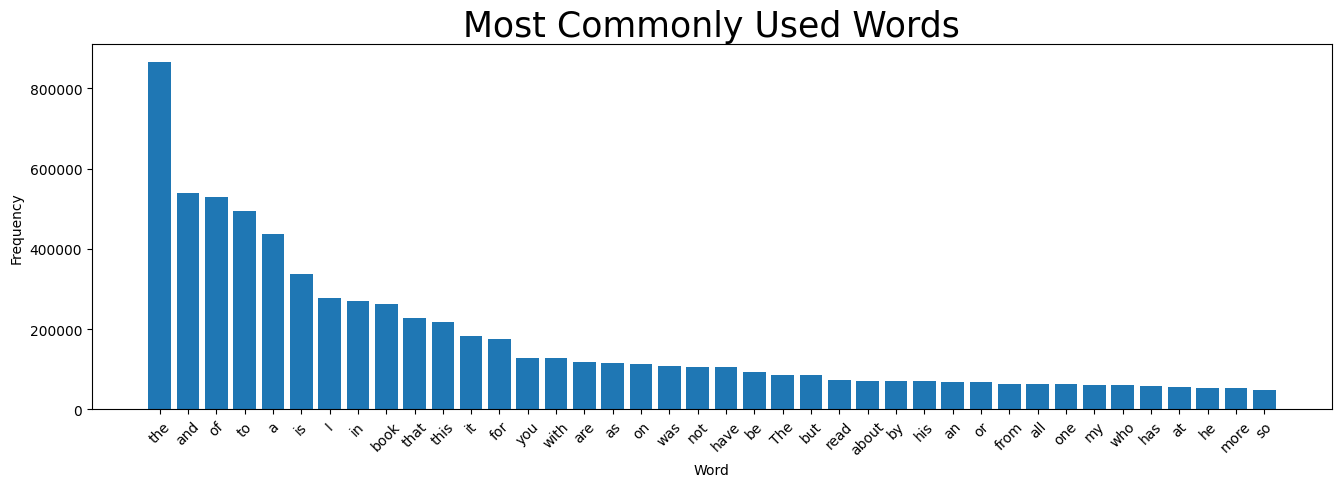

In [6]:
# evaluate most used words
def MostWordsUsed(txt , n_words) :
    all_text = ''.join(df[txt].values)

    all_text = re.sub(r'\d+', '', all_text) # numbers
    all_text = re.sub(r'[^\w\s]', '', all_text) # special characters

    words = all_text.split()

    word_counts = Counter(words)

    top_words = word_counts.most_common(n_words)

    return top_words

top_words = MostWordsUsed('Review' , 40)

xaxis = [word[0] for word in top_words]
yaxis = [word[1] for word in top_words]

plt.figure(figsize=(16,5))
plt.bar(xaxis , yaxis)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Commonly Used Words', fontsize=25)
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.15)
plt.show()

In [4]:
# split data into training set and validation set
# 'cleand_reviews' as feature variable and 'IsHelpful' as target that is to be predicted for training
# 80% of the data will be used for training
x_train , x_val , y_train , y_val = train_test_split(df['cleaned_reviews'] , df['IsHelpful'] , train_size = 0.80 , random_state = 42)
len(x_train) , len(x_val)

(109644, 27411)

In [6]:
# feature extraction
# "feature words" = eindeutigen Wörter oder Terme im Vokabular, die als Features für die Darstellung der Dokumente verwendet werden. Jedes Dokument wird als Vektor von TF-IDF-Werten für diese feature words dargestellt.

# Replace NaN with empty string
x_train = x_train.replace(np.nan, '', regex=True)

# Feature extraction
vec = TfidfVectorizer(max_features=50000) # ca 10% von Datensatz Phones
vec.fit(x_train)
print("No. of feature words: ", len(vec.get_feature_names_out()))

No. of feature words:  50000


In [7]:
x_train = vec.transform(x_train).toarray()
x_val = vec.transform(x_val).toarray()

## Logistic Regression
#### mit knapp 300k feature words

In [9]:
lr = LogisticRegression(random_state=42)
lr.fit(x_train , y_train)

LogisticRegression(random_state=42)

In [10]:
train_acc1 = lr.score(x_train , y_train)

lr_pred = lr.predict(x_val)

val_acc1 = accuracy_score(y_val , lr_pred)

val_precision1 = precision_score(y_val , lr_pred , average='weighted')
val_recall1 = recall_score(y_val , lr_pred , average='weighted')
val_f1score1 = f1_score(y_val , lr_pred , average='weighted')

print(f"The training accuracy for logistic regression : {(train_acc1*100):0.2f}%\n")
print(f"The validation accuracy for logistic regression : {(val_acc1*100):0.2f}%\n")
print(f"The precision for logistic regression : {val_precision1:0.2f}\n")
print(f"The recall for logistic regression : {val_recall1:0.2f}\n")
print(f"The f1 score for logistic regression : {val_f1score1:0.2f}\n")

The training accuracy for logistic regression : 84.33%

The validation accuracy for logistic regression : 78.87%

The precision for logistic regression : 0.79

The recall for logistic regression : 0.79

The f1 score for logistic regression : 0.79



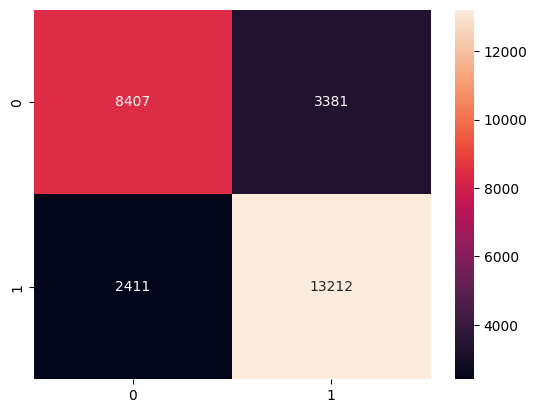

In [11]:
lr_cm = confusion_matrix(y_val , lr_pred)
sns.heatmap(lr_cm, annot=True,fmt='3g')
plt.show()

## Random Forest
#### mit 50k feature words

In [8]:
rf = RandomForestClassifier()
rf.fit(x_train , y_train)

RandomForestClassifier()

In [10]:
train_acc2 = rf.score(x_train , y_train)

rf_pred = rf.predict(x_val)

val_acc2 = accuracy_score(y_val , rf_pred)

val_precision2 = precision_score(y_val , rf_pred , average='weighted')
val_recall2 = recall_score(y_val , rf_pred , average='weighted')
val_f1score2 = f1_score(y_val , rf_pred , average='weighted')

print(f"The training accuracy for Random Forest : {(train_acc2*100):0.2f}%\n")
print(f"The validation accuracy for Random Forest : {(val_acc2*100):0.2f}%\n")
print(f"The precision for Random Forest : {val_precision2:0.2f}\n")
print(f"The recall for Random Forest : {val_recall2:0.2f}\n")
print(f"The f1 score for Random Forest : {val_f1score2:0.2f}\n")

The training accuracy for Random Forest : 100.00%

The validation accuracy for Random Forest : 75.38%

The precision for Random Forest : 0.76

The recall for Random Forest : 0.75

The f1 score for Random Forest : 0.75



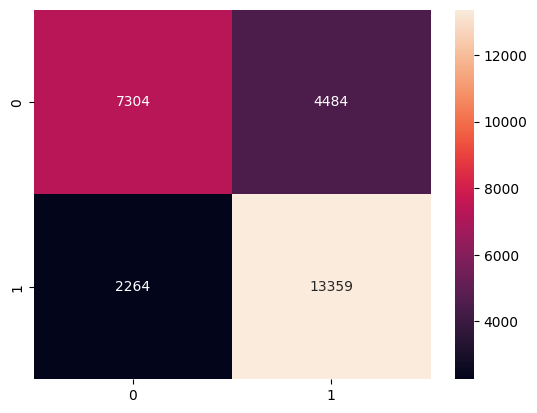

In [12]:
rf_cm = confusion_matrix(y_val , rf_pred)
sns.heatmap(rf_cm, annot=True,fmt='3g')
plt.show()

## Compare Models

In [22]:
# Hardcoded LR values, weil LR model nicht mehr in der Session gespeichert war
train_acc1 = 0.8433
val_acc1 = 0.7887

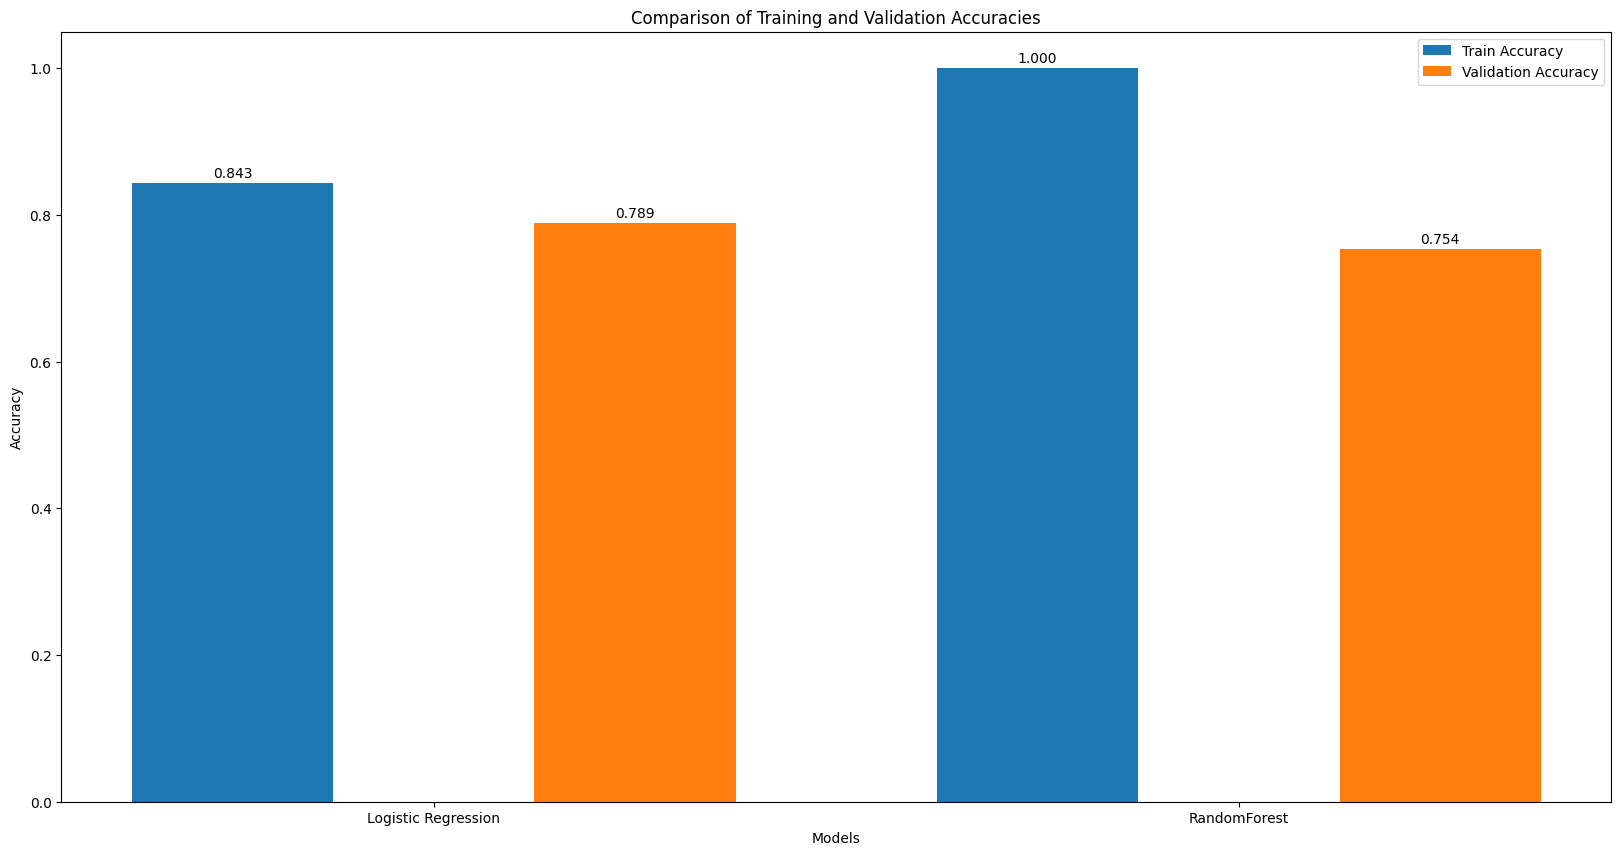

In [23]:
train_scores=[train_acc1,train_acc2]
val_scores=[val_acc1,val_acc2]

models = ['Logistic Regression','RandomForest']

x = np.arange(len(models))

width = 0.25

fig, ax = plt.subplots(figsize=(20, 10))

rects1 = ax.bar(x - width, train_scores, width, label='Train Accuracy')

rects2 = ax.bar(x + width, val_scores, width, label='Validation Accuracy')

ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Training and Validation Accuracies')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 2),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

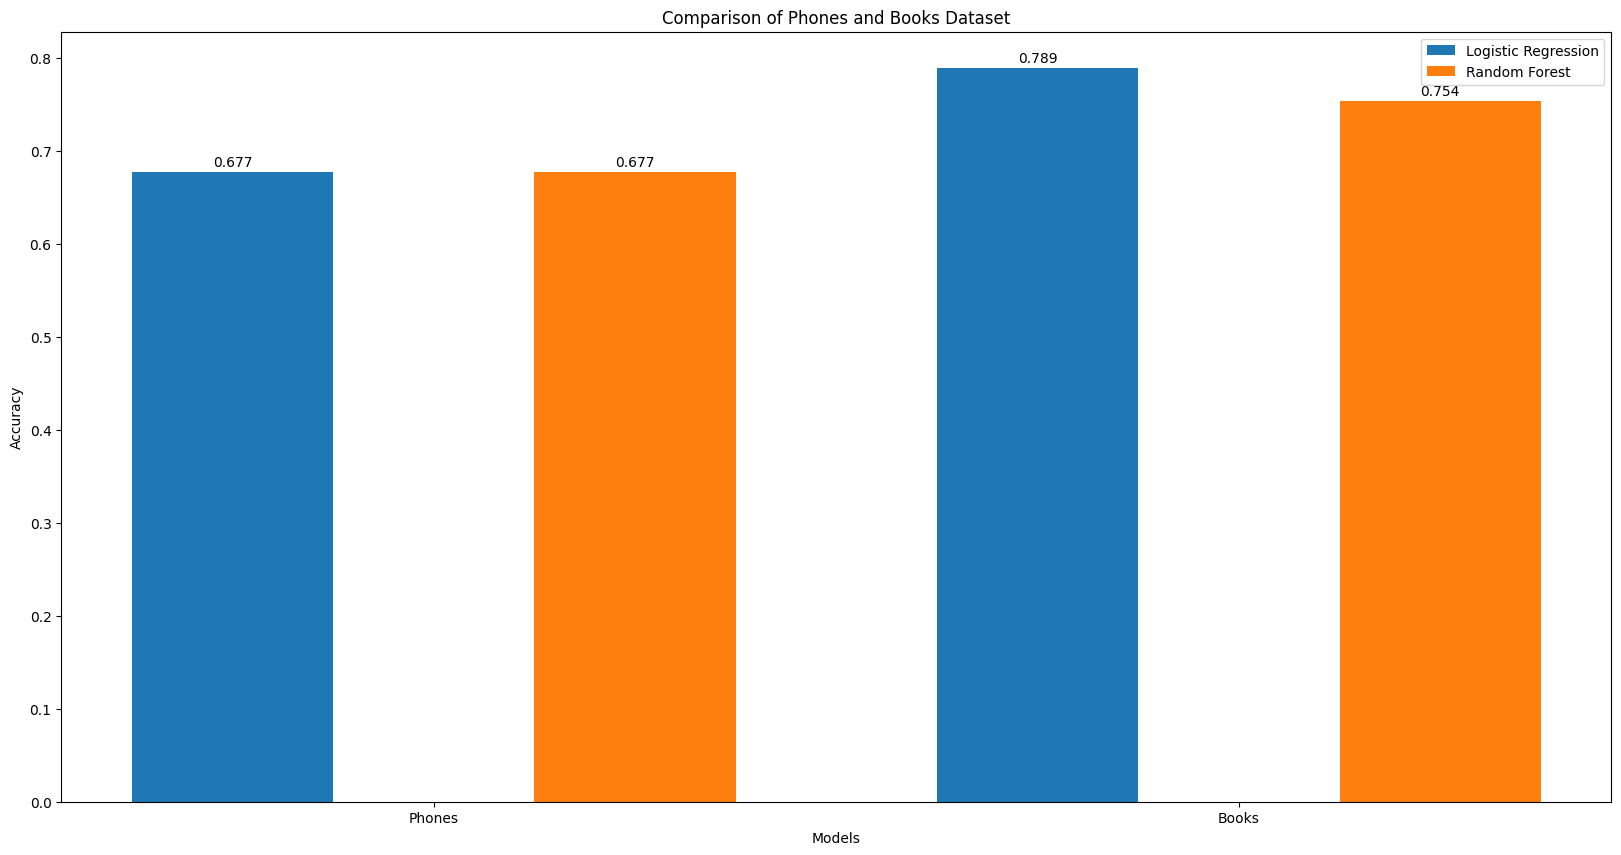

In [24]:
## Comparison of validation accuracy to smaller Dataset

lr_phones_books=[0.677,val_acc1]
rf_phones_books=[0.677,val_acc2]

models = ['Phones','Books']

x = np.arange(len(models))

width = 0.25

fig, ax = plt.subplots(figsize=(20, 10))

rects1 = ax.bar(x - width, lr_phones_books, width, label='Logistic Regression')

rects2 = ax.bar(x + width, rf_phones_books, width, label='Random Forest')

ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Phones and Books Dataset')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 2),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()